# FOOOFing EEG Data

Analyzing EEG dataset.

In [1]:
%matplotlib inline

import os
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

# MNE & associated code
import mne
from mne.preprocessing import ICA
from autoreject import LocalAutoRejectCV

# FOOOF, and custom helper & utility functions
from fooof import FOOOF, FOOOFGroup
from fooof.analysis import get_band_peak, get_band_peak_group

from om.core.utils import clean_file_list

/Users/tom/anaconda/envs/eeg36/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Import custom code for this analysis
import sys
sys.path.append('/Users/tom/Documents/GitCode/EEGFOOOF/scripts/')

from utils import *

### Data Groups

Group 1 is the original group of 11 (young) subjects (set files). 

Group 2 is a different group, of 17 young and 14 old adults (bdf files). 

In [3]:
# Set which group of data to run
GROUP = 'G2'

In [4]:
# Set paths & settings
dat_path = os.path.join('/Users/tom/Documents/Data/Voytek_WMData/', GROUP)
extension = '.set' if GROUP == 'G1' else '.bdf'

In [5]:
# Get list of subject files
subj_files = os.listdir(dat_path)
subj_files = clean_file_list(subj_files, extension)

In [6]:
# Set subject index to load (as index from subjs_files)
sub_ind = 4

# Load data, and do group specific things for fixing up the channel labels & types
if GROUP == 'G1':

    eeg_dat = mne.io.read_raw_eeglab(os.path.join(dat_path, subj_files[sub_ind]), preload=True)
    
    # Set channel types
    ch_types = {'LO1' : 'eog', 'LO2' : 'eog', 'IO1' : 'eog', 'A1' : 'misc', 'A2' : 'misc'}
    
if GROUP == 'G2':
   
    eeg_dat = mne.io.read_raw_edf(os.path.join(dat_path, subj_files[sub_ind]), preload=True)

    # Fix channel name labels
    eeg_dat.info['ch_names'] = [chl[2:] for chl in eeg_dat.ch_names[:-1]] + [eeg_dat.ch_names[-1]]
    for ind, chi in enumerate(eeg_dat.info['chs']):
        eeg_dat.info['chs'][ind]['ch_name'] = eeg_dat.info['ch_names'][ind]
    
    # Set channel types
    ch_types = {'LHor' : 'eog', 'RHor' : 'eog', 'IVer' : 'eog', 'SVer' : 'eog',
                'LMas' : 'misc', 'RMas' : 'misc', 'Nose' : 'misc', 'EXG8' : 'misc'}

# Set channel types
eeg_dat.set_channel_types(ch_types)

stim_channel will default to 'auto' in version 0.16. Set stim_channel explicitly to avoid this warning.
Extracting edf Parameters from /Users/tom/Documents/Data/Voytek_WMData/G2/OA_060507_RAW.bdf...
BDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 1381375  =      0.000 ...  2697.998 secs...


<ipython-input-6-39678eb283c2>:14: DeprecationWarning: stim_channel will default to 'auto' in version 0.16. Set stim_channel explicitly to avoid this warning.
  eeg_dat = mne.io.read_raw_edf(os.path.join(dat_path, subj_files[sub_ind]), preload=True)


Ready.


In [7]:
# Set to keep current reference
eeg_dat.set_eeg_reference(ref_channels=[])

# Set average reference
#eeg_dat.set_eeg_reference(ref_channels='average')
#eeg_dat.apply_proj()

# Set specific reference
#eeg_dat.set_eeg_reference(['Cz'])
#eeg_dat.set_eeg_reference(['A1', 'A2'])

EEG data marked as already having the desired reference. Preventing automatic future re-referencing to an average reference.


<RawEDF  |  OA_060507_RAW.bdf, n_channels x n_times : 73 x 1381376 (2698.0 sec), ~769.5 MB, data loaded>

In [8]:
# Get sampling rate
srate = eeg_dat.info['sfreq']

# Check if there are any channels marked bad
eeg_dat.info['bads']

[]

In [9]:
# Check EEG data information
#eeg_dat.info

### Montage

In [10]:
# Set channel montage
chs = mne.channels.read_montage('standard_1020', eeg_dat.ch_names)
eeg_dat.set_montage(chs)

<RawEDF  |  OA_060507_RAW.bdf, n_channels x n_times : 73 x 1381376 (2698.0 sec), ~769.5 MB, data loaded>

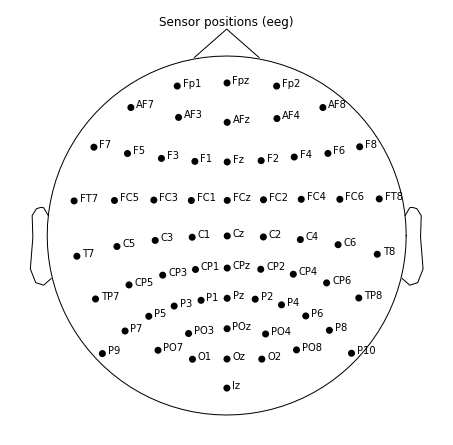

In [11]:
# Check channel positions
eeg_dat.plot_sensors(show_names=True);

### Pre-Processing: ICA

In [12]:
# High-pass filter for ICA
#eeg_dat.filter(l_freq=1, h_freq=None, fir_design='firwin');

In [13]:
# Initialize and fit ICA
#ica = ICA(method='fastica')
#ica = ICA(n_components=0.99, method='fastica')
#ica.fit(eeg_dat)

In [14]:
# # ?
# heog_inds, h_scores = ica.find_bads_eog(eeg_dat, ch_name='LO1', threshold=3.0, l_freq=1, h_freq=10)
# print(heog_inds)

# ica.plot_scores(h_scores, exclude=heog_inds, labels='eog');

In [15]:
# # ?
# veog_inds, v_scores = ica.find_bads_eog(eeg_dat, ch_name='IO1', threshold=3.0, l_freq=1, h_freq=10)
# print(veog_inds)

# ica.plot_scores(v_scores, exclude=veog_inds, labels='eog');

In [16]:
# #
# drop_inds = list(set(heog_inds + veog_inds))
# ica.exclude = drop_inds

# print(ica.exclude)

In [17]:
#
#ica.plot_components();

In [18]:
#ica.plot_properties(eeg_dat, picks=drop_inds)

In [19]:
#ica.plot_overlay?

In [20]:
#ica.plot_overlay(eeg_dat, exclude=drop_inds);

In [21]:
# Apply ICA to data
#ica.apply(eeg_dat);

## Event management

In [22]:
# Get event information
evs = mne.find_events(eeg_dat, shortest_event=1, verbose=False)

# Check all used event codes
ev_codes = np.unique(evs[:, 2])

# Pull out sampling rate
srate = eeg_dat.info['sfreq']

In [23]:
# Set up event code dictionary, with key labels for each event type
ev_dict = {'LeLo1': [201, 202], 'LeLo2': [205, 206], 'LeLo3': [209, 210], 
           'RiLo1': [203, 204], 'RiLo2': [207, 208], 'RiLo3': [211, 212]}

# Event codes for correct and incorrect codes
corr_codes = [2, 1]
inco_codes = [102, 101]

In [24]:
# Extract a list of all the event labels
all_trials = [it for it2 in ev_dict.values() for it in it2]

# Create list of new event codes to be used to label correct trials (300s)
all_trials_new = [it + 100 for it in all_trials]
# This is an annoying way to collapse across the doubled event markers from above
all_trials_new = [it - 1 if not ind%2 == 0 else it for ind, it in enumerate(all_trials_new)]
# Get labelled dictionary of new event names
ev_dict2 = {k:v for k, v in zip(ev_dict.keys(), set(all_trials_new))}

In [25]:
# Initialize variables to store new event definitions
evs2 = np.empty(shape=[0, 3], dtype='int64')
lags = np.array([])

# Loop through, creating new events for all correct trials
t_min, t_max = -0.4, 3.0
for ref_id, targ_id, new_id in zip(all_trials, corr_codes * 6, all_trials_new):
    
    t_evs, t_lags = mne.event.define_target_events(evs, ref_id, targ_id, srate, t_min, t_max, new_id)
    
    if len(t_evs) > 0:
        evs2 = np.vstack([evs2, t_evs])
        lags = np.concatenate([lags, t_lags])

In [26]:
# Check how many of each event type there are
print(Counter(evs[:, 2]))
print('\n')
print(Counter(evs2[:, 2]))

Counter({55: 800, 1: 396, 2: 384, 203: 70, 204: 70, 209: 70, 206: 70, 208: 70, 207: 70, 202: 70, 205: 70, 210: 60, 201: 60, 212: 60, 211: 60, 101: 13, 11: 12, 65536: 8})


Counter({303: 139, 305: 138, 307: 137, 301: 127, 309: 123, 311: 116})


### FOOOF 

In [27]:
# Set channel of interest
ch_ind = eeg_dat.ch_names.index('Oz')

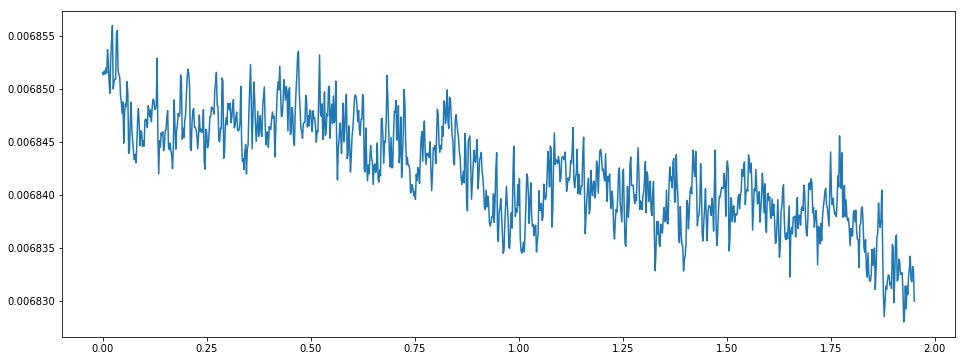

In [28]:
# Plot a segment of data - to eyeball
inds = [0, 1000]
fig = plt.figure(figsize=[16, 6])
plt.plot(eeg_dat.times[inds[0]:inds[1]], eeg_dat._data[ch_ind, inds[0]:inds[1]])

In [29]:
# Calculate PSDs (across all channels) - from the first 2 minute of data
psds, freqs = mne.time_frequency.psd_welch(eeg_dat, fmin=2, fmax=40, tmin=0 ,tmax=120,
                                           n_fft=int(2*srate), n_overlap=int(srate), verbose=False)

In [30]:
# Initialize FOOOFGroup object
f_range = [3, 25]
fg = FOOOFGroup(peak_width_limits=[1, 8])

# Run FOOOF across all power spectra
fg.fit(freqs, psds, f_range, n_jobs=-1)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 25 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         -12.2337, 0.6583                                         
                                                                                                  
                                       1 peaks were found:                                        
          

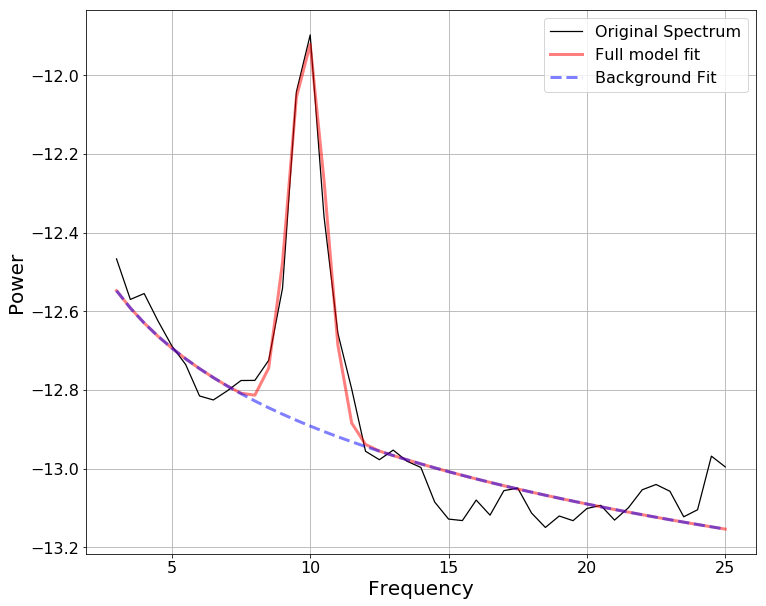

In [31]:
# Check FOOOF model fit of particular channel of interest
fm = fg.get_fooof(ch_ind, True)
fm.print_results()
fm.plot()

In [32]:
# Extract individualized CF from channel Oz
fooof_freq, _, fooof_bw = get_band_peak(fm.peak_params_, [7, 13])#[0]
print('Alpha CF: \t{:0.4f}'.format(fooof_freq))
print('Alpha BW: \t{:0.4f}'.format(fooof_bw))

Alpha CF: 	9.8928
Alpha BW: 	1.3056


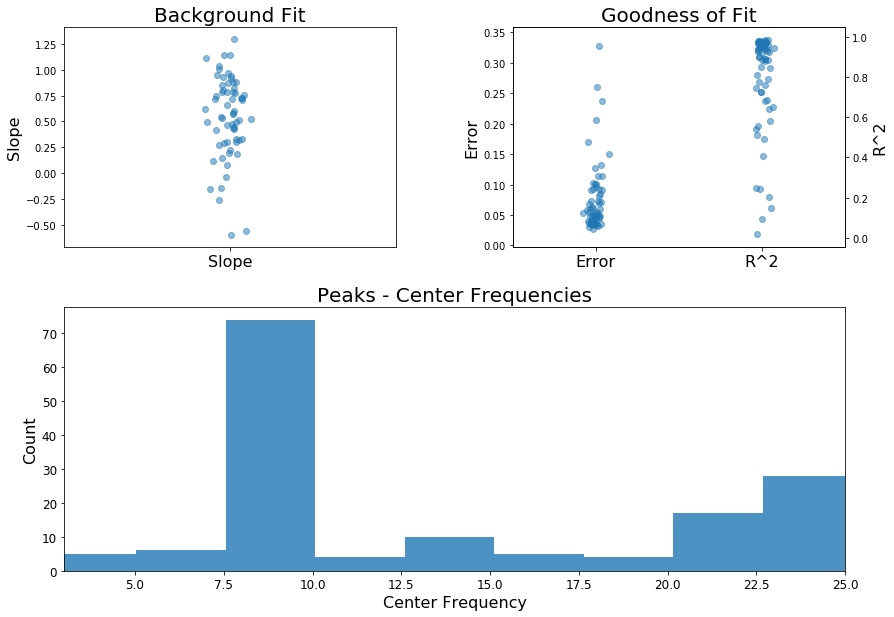

In [33]:
# Check a summary of the FOOOFGroup results across all channels
fg.plot()

In [34]:
# Extract alpha oscillations - all channels
alphas = get_band_peak_group(fg.get_all_data('peak_params'), [7, 13], len(fg))

## Filtering & Envelope

#### Canonical Alpha Range

In [35]:
# Filter data to canonical alpha band: 8-12 Hz
alpha_dat = eeg_dat.copy()
alpha_dat.filter(8, 12, fir_design='firwin')

Setting up band-pass filter from 8 - 12 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 3.0 Hz
Filter length of 845 samples (1.650 sec) selected


<RawEDF  |  OA_060507_RAW.bdf, n_channels x n_times : 73 x 1381376 (2698.0 sec), ~769.5 MB, data loaded>

#### FOOOF defined subject-specific alpha band

In [36]:
# Filter data to FOOOF derived alpha band
fooof_dat = eeg_dat.copy()
fooof_dat.filter(fooof_freq-2, fooof_freq+2, fir_design='firwin')

#filt_bw = fooof_bw * 1.5
#fooof_dat.filter(fooof_freq-filt_bw, fooof_freq+filt_bw, fir_design='firwin')

Setting up band-pass filter from 7.9 - 12 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 3.0 Hz
Filter length of 845 samples (1.650 sec) selected


<RawEDF  |  OA_060507_RAW.bdf, n_channels x n_times : 73 x 1381376 (2698.0 sec), ~769.5 MB, data loaded>

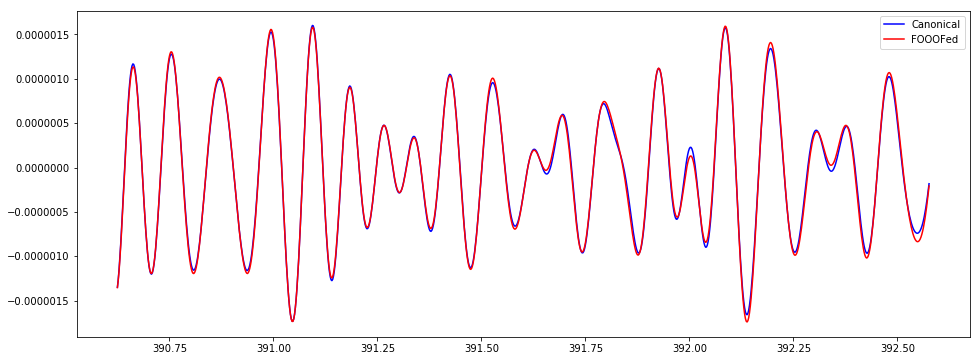

In [37]:
# Plot the differently filtered traces - check for differences
inds = [200000, 201000] # Arbitrary time points
fig = plt.figure(figsize=[16, 6])
plt.plot(alpha_dat.times[inds[0]:inds[1]], alpha_dat._data[ch_ind, inds[0]:inds[1]], 'b', label='Canonical')
plt.plot(fooof_dat.times[inds[0]:inds[1]], fooof_dat._data[ch_ind, inds[0]:inds[1]], 'r', label='FOOOFed')
plt.legend()

In [38]:
# Take the analytic amplitude (hilbert) of the alpha-filtered signals
alpha_dat.apply_hilbert(envelope=True)
fooof_dat.apply_hilbert(envelope=True)

<RawEDF  |  OA_060507_RAW.bdf, n_channels x n_times : 73 x 1381376 (2698.0 sec), ~769.5 MB, data loaded>

### Epoching

In [59]:
# Epoch settings
tmin, tmax = -0.5, 1.2

# Epoch trials - raw data for trial rejection
epochs = mne.Epochs(eeg_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=(-0.5, -0.35), preload=True)

# Epoch trials - filtered version
epochs_alpha = mne.Epochs(alpha_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=(-0.50, -0.35), preload=True);
epochs_fooof = mne.Epochs(fooof_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=(-0.50, -0.35), preload=True);

The events passed to the Epochs constructor are not chronologically ordered.
780 matching events found
0 projection items activated
Loading data for 780 events and 871 original time points ...


<ipython-input-59-5aee56d0710e>:5: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(eeg_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=(-0.5, -0.35), preload=True)


0 bad epochs dropped
The events passed to the Epochs constructor are not chronologically ordered.
780 matching events found
0 projection items activated
Loading data for 780 events and 871 original time points ...


<ipython-input-59-5aee56d0710e>:8: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs_alpha = mne.Epochs(alpha_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=(-0.50, -0.35), preload=True);


0 bad epochs dropped
The events passed to the Epochs constructor are not chronologically ordered.
780 matching events found
0 projection items activated
Loading data for 780 events and 871 original time points ...


<ipython-input-59-5aee56d0710e>:9: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs_fooof = mne.Epochs(fooof_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=(-0.50, -0.35), preload=True);


0 bad epochs dropped


### Pre-Processing: Autoreject

In [40]:
# Initialize and run autoreject across epochs
#ar = LocalAutoRejectCV()
#epochs = ar.fit_transform(epochs)

In [41]:
# Check which epochs are dropped
#ar.bad_epochs_idx

In [42]:
# Drop same trials from filtered data
#epochs_alpha.drop(ar.bad_epochs_idx)
#epochs_fooof.drop(ar.bad_epochs_idx)

### Set channel clusters

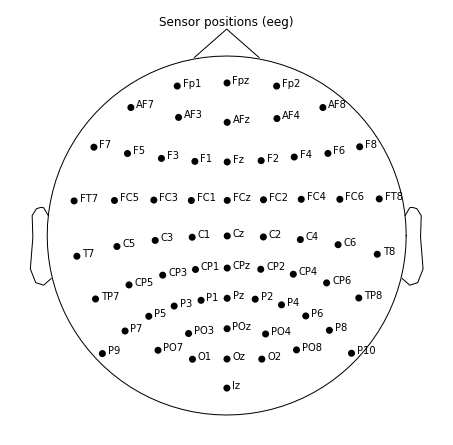

In [43]:
# Replot channel positions
eeg_dat.plot_sensors(show_names=True);

In [44]:
# Set channel clusters for analysis - take channels contralateral to stimulus presentation
le_chs = ['P3', 'P5', 'P7', 'P9', 'O1', 'PO3', 'PO7']
le_inds = [epochs.ch_names.index(chn) for chn in le_chs]
ri_chs = ['P4', 'P6', 'P8', 'P10', 'O2', 'PO4', 'PO8']
ri_inds = [epochs.ch_names.index(chn) for chn in ri_chs]

### Trial-Related Analysis

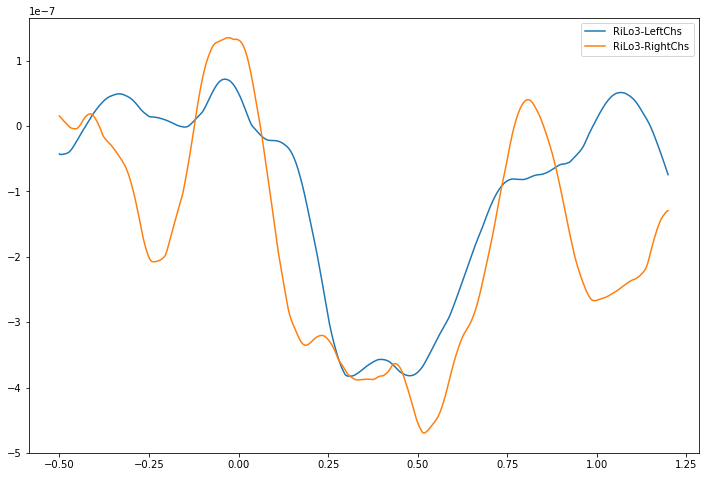

In [45]:
# Check lateralized alpha response for particular trial type
trial_type = 'RiLo3'
times = np.arange(-0.5, 1.2, 1/srate)
plt.figure(figsize=[12, 8])
plt.plot(times, np.mean(epochs_alpha[trial_type]._data[:, le_inds, :], 0).T[:, 0], label=trial_type+'-LeftChs')
plt.plot(times, np.mean(epochs_alpha[trial_type]._data[:, ri_inds, :], 0).T[:, 0], label=trial_type+'-RightChs')
plt.legend();

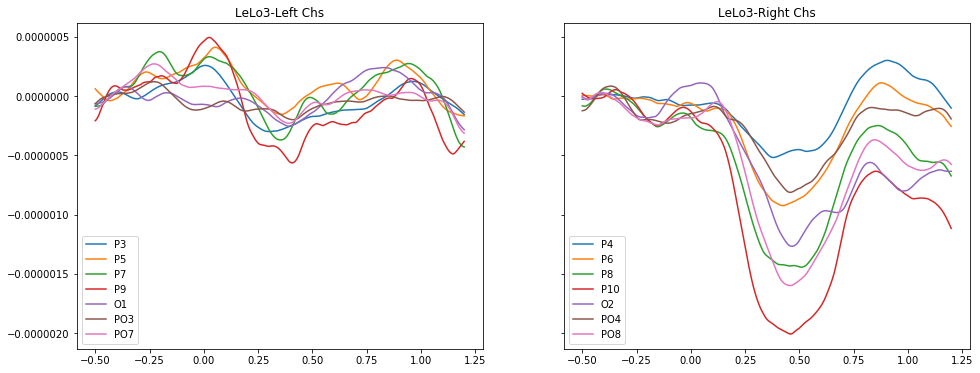

In [46]:
# Plot the responses across channels
trial_type = 'LeLo3'
times = np.arange(-0.5, 1.2, 1/srate)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=[16, 6])

ax1.plot(times, np.mean(epochs_alpha[trial_type]._data[:, le_inds, :], 0).T);
ax1.set_title(trial_type+'-Left Chs')
ax1.legend(le_chs);

ax2.plot(times, np.mean(epochs_alpha[trial_type]._data[:, ri_inds, :], 0).T);
ax2.set_title(trial_type+'-Right Chs')
ax2.legend(ri_chs);

In [47]:
# Pull out channel of interest for each load level - canonical data
#  Channels extracted are those contralateral to stimulus presentation
lo1_a = np.concatenate([epochs_alpha['LeLo1']._data[:, ri_inds, :], epochs_alpha['RiLo1']._data[:, le_inds, :]], 0)
lo2_a = np.concatenate([epochs_alpha['LeLo2']._data[:, ri_inds, :], epochs_alpha['RiLo2']._data[:, le_inds, :]], 0)
lo3_a = np.concatenate([epochs_alpha['LeLo3']._data[:, ri_inds, :], epochs_alpha['RiLo3']._data[:, le_inds, :]], 0)

In [48]:
# Pull out channel of interest for each load level - fooofed data
#  Channels extracted are those contralateral to stimulus presentation
lo1_f = np.concatenate([epochs_fooof['LeLo1']._data[:, ri_inds, :], epochs_fooof['RiLo1']._data[:, le_inds, :]], 0)
lo2_f = np.concatenate([epochs_fooof['LeLo2']._data[:, ri_inds, :], epochs_fooof['RiLo2']._data[:, le_inds, :]], 0)
lo3_f = np.concatenate([epochs_fooof['LeLo3']._data[:, ri_inds, :], epochs_fooof['RiLo3']._data[:, le_inds, :]], 0)

In [49]:
# Calculate average across trials and channels
lo1_a_avg = np.mean(lo1_a, 1).mean(0)
lo2_a_avg = np.mean(lo2_a, 1).mean(0)
lo3_a_avg = np.mean(lo3_a, 1).mean(0)
canonical_avg = np.vstack([lo1_a_avg, lo2_a_avg, lo3_a_avg])

# Calculate average across trials and channels
lo1_f_avg = np.mean(lo1_f, 1).mean(0)
lo2_f_avg = np.mean(lo2_f, 1).mean(0)
lo3_f_avg = np.mean(lo3_f, 1).mean(0)
fooofed_avg = np.vstack([lo1_f_avg, lo2_f_avg, lo3_f_avg])

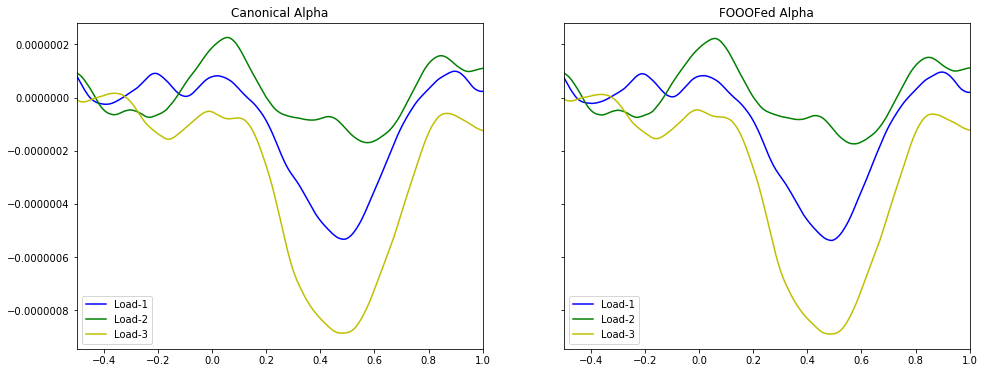

In [50]:
# Plot alpha response between different alpha filters
plot_alpha_response_compare(canonical_avg, fooofed_avg, srate)

## FOOOFING TRIAL AVERAGED DATA

In [51]:
# Initialize FOOOF object
fm = FOOOF(peak_width_limits=[1, 6], min_peak_amplitude=0.1, peak_threshold=1.5)

# Initialize dictionary to store FOOOF results
fm_dict = {'Load1' : [], 'Load2' : [], 'Load3' : []}

In [52]:
# Settings for trial averaged FOOOFing
fmin, fmax = 3, 25
tmin, tmax = -0.1, 1.1
n_fft, n_overlap, n_per_seg = 4*srate, srate/2, srate*2

In [57]:
# Loop through loads
for le_label, ri_label, load in zip(['LeLo1', 'LeLo2', 'LeLo3'],
                                    ['RiLo1', 'RiLo2', 'RiLo3'], 
                                    ['Load1', 'Load2', 'Load3']):
    
    # Calculate trial wise PSDs - left side trials
    le_trial_psds, trial_freqs = mne.time_frequency.psd_welch(epochs[le_label], fmin, fmax, tmin=tmin, tmax=tmax,
                                                              n_fft=n_fft, n_overlap=n_overlap, n_per_seg=n_per_seg,
                                                              verbose=False)
    le_avg_psd = np.mean(le_trial_psds[:, ri_inds, :], 0).mean(0)
    
    # Calculate trial wise PSDs - right side trials
    ri_trial_psds, trial_freqs = mne.time_frequency.psd_welch(epochs[ri_label], fmin, fmax, tmin=tmin, tmax=tmax,
                                                              n_fft=n_fft, n_overlap=n_overlap, n_per_seg=n_per_seg,
                                                              verbose=False)
    ri_avg_psd = np.mean(ri_trial_psds[:, le_inds, :], 0).mean(0)

    avg_psd = np.mean(np.vstack([le_avg_psd, ri_avg_psd]), 0)
    
    # Fit FOOOF, and collect results
    fm.fit(trial_freqs, avg_psd)
    fm_dict[load] = fm.copy()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 25 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         -11.7483, 0.7164                                         
                                                                                                  
                                       2 peaks were found:                                        
          

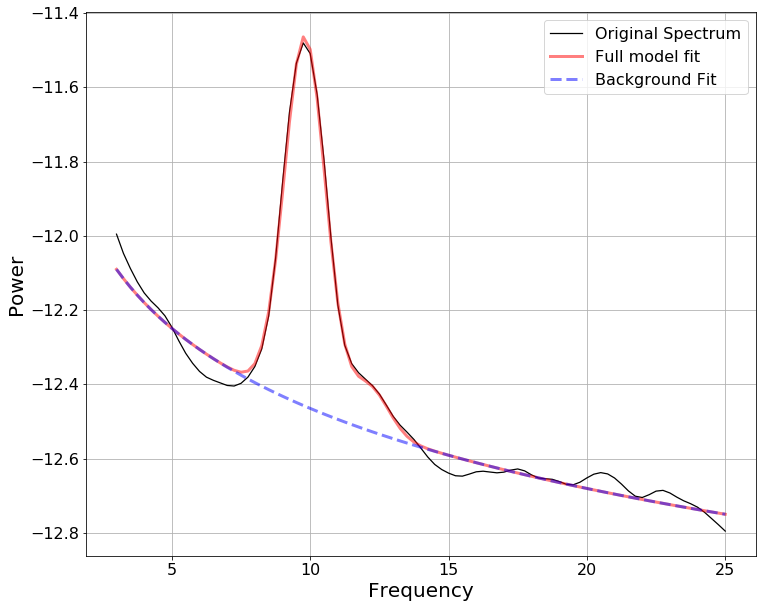

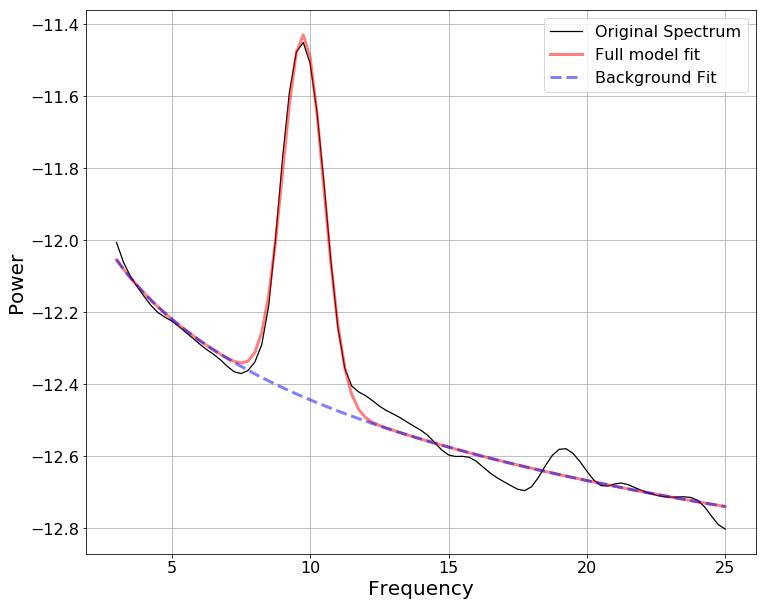

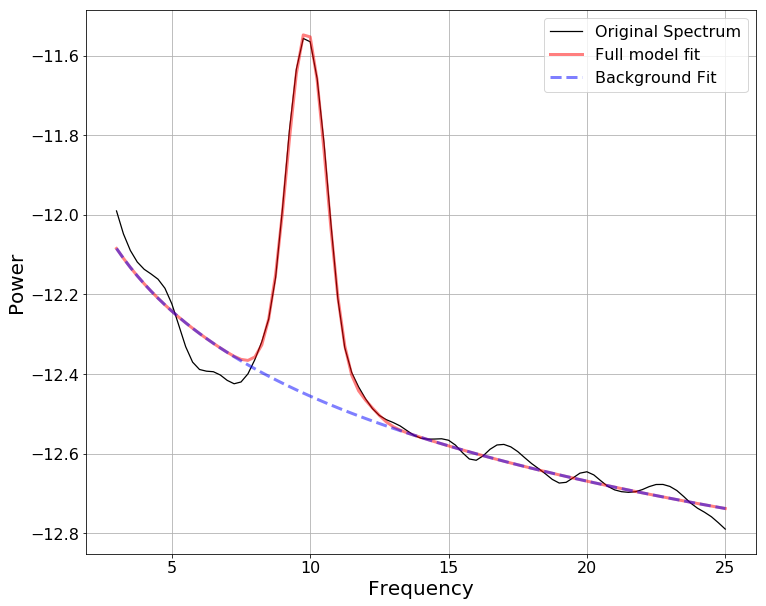

In [58]:
# Print & plot trial average results
for fm in fm_dict.values():
    fm.print_results()
    fm.plot()